In [2]:
import maboss
from tqdm import tqdm
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

work_dir = '/home/spankaew/Git/BooleanBenchmark/'
project = 'herault_hematopoiesis'
model_dir = work_dir + 'models/' + project + '/'
output_dir = work_dir + 'simulation_files/'
traj_dir = work_dir + 'models/' 

In [3]:
traj_data = pd.read_csv(traj_dir + project+'_traj_df.csv', index_col= 0)
initial_state = traj_data.loc['iHSC']
node_inactive = list(initial_state.index[initial_state==0])
node_active = list(initial_state.index[initial_state==1])

In [6]:
# Create blank file to get the results
ensemble_results = {}
 
model_list = os.listdir(model_dir)

for model in tqdm(model_list):

    # Load model
    simulations = maboss.loadBNet(model_dir + model)

    # Setup the model initial condition
    ## Put all inputs at 0
    for i in node_inactive:
        simulations.network.set_istate(i,[1,0])
    ## Put all miR at 1
    for i in node_active:
        simulations.network.set_istate(i,[0,1])

    # Modify the parameter of the model
    simulations.update_parameters(sample_count = 10000,
                                  thread_count = 15,
                                  max_time = 40,
                                  time_tick = 1)
    simulations.network.set_output(simulations.network.names)

    # Perform simulations
    result = simulations.run()

    # Get matrix
    model_mtx = result.get_nodes_probtraj().copy()

    # Setup cell matrix
    ## Cells
    model_mtx['model_id'] = model.replace('.bnet','')
    ## Timepoint
    model_mtx['timepoint'] = model_mtx.index
    ## Change index
    model_mtx.index = model_mtx.index.map(str)
    model_mtx.index = model + '_' + model_mtx.index

    # Concatenate model results in dictionary
    ensemble_results[model] = model_mtx

# Save the simulation to /tmp folder
simulation_df = pd.concat(ensemble_results.values(), ignore_index = True)
simulation_df.to_csv(output_dir + project +'_simulation.csv')

100%|██████████| 617/617 [01:32<00:00,  6.69it/s]


In [7]:
cl_df = pd.read_csv(output_dir + project+'_simulation.csv', index_col = 0)
cl_df.index = cl_df.model_id + '_' + [str(f) for f in cl_df.timepoint]
cl_df.index.name = None

In [8]:
adata = sc.AnnData(cl_df.drop(['model_id','timepoint'],axis = 1))
adata.obs['timepoint'] = cl_df['timepoint']
adata.obs['model_id'] = cl_df['model_id']

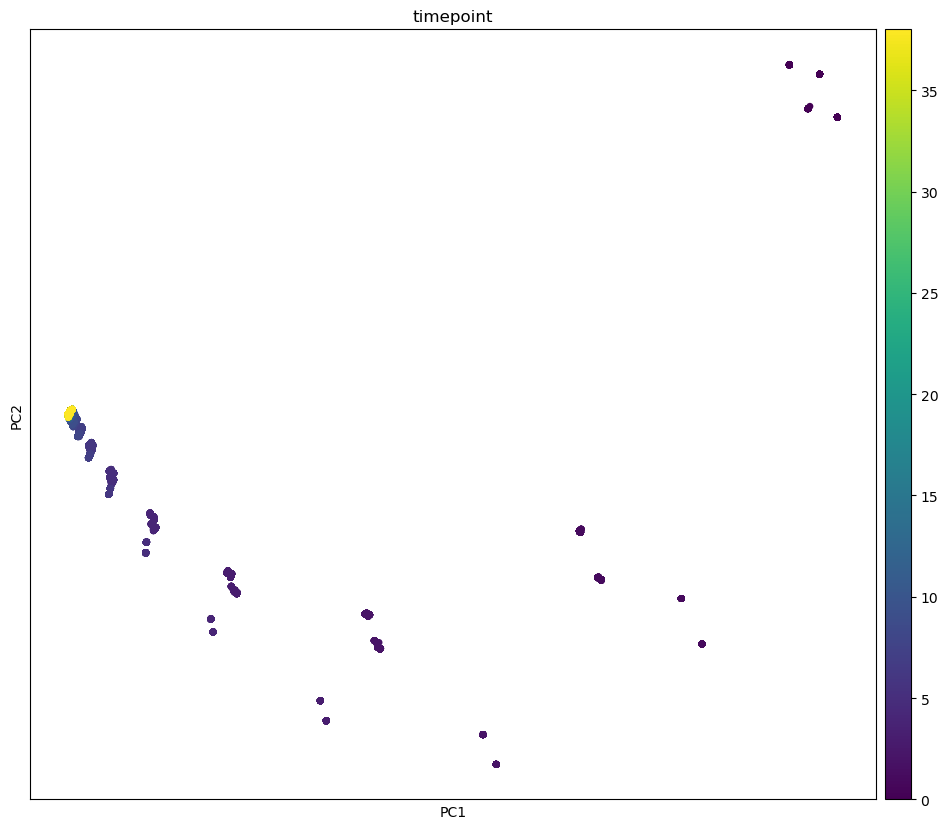

In [9]:
# Calculate PCA
sc.tl.pca(adata, svd_solver='arpack')

# plot 
from matplotlib.pyplot import rc_context
with rc_context({"figure.figsize": (12, 10)}):
    sc.pl.pca(adata, color = 'timepoint', size = 100)

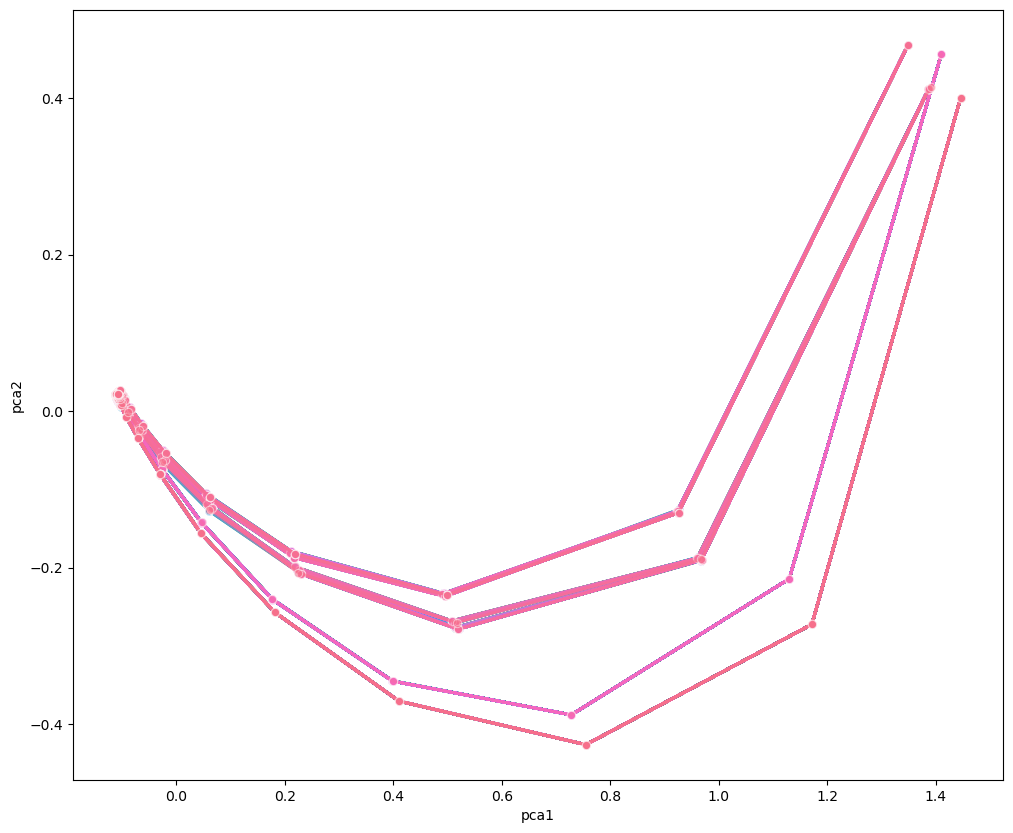

In [10]:
# Convert the PCA position to timeseries data
pca_mat = [array[:2] for array in adata.obsm['X_pca']]
pca_mat = pd.DataFrame(pca_mat, columns= ['pca1','pca2'])
pca_mat.index = adata.obs.index
pca_mat = pd.concat([pca_mat, adata.obs], axis = 1,ignore_index = False)

# plot
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_mat, 
                        x = 'pca1',y='pca2',
                        hue = 'model_id', sort = False,
                        marker = 'o', linewidth = 2,
                        alpha = .5 
                        #markersize = 10
                        )
    plot.get_legend().remove()

plt.show()

/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/spankaew/anaconda3/envs/scPROFILE/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, me

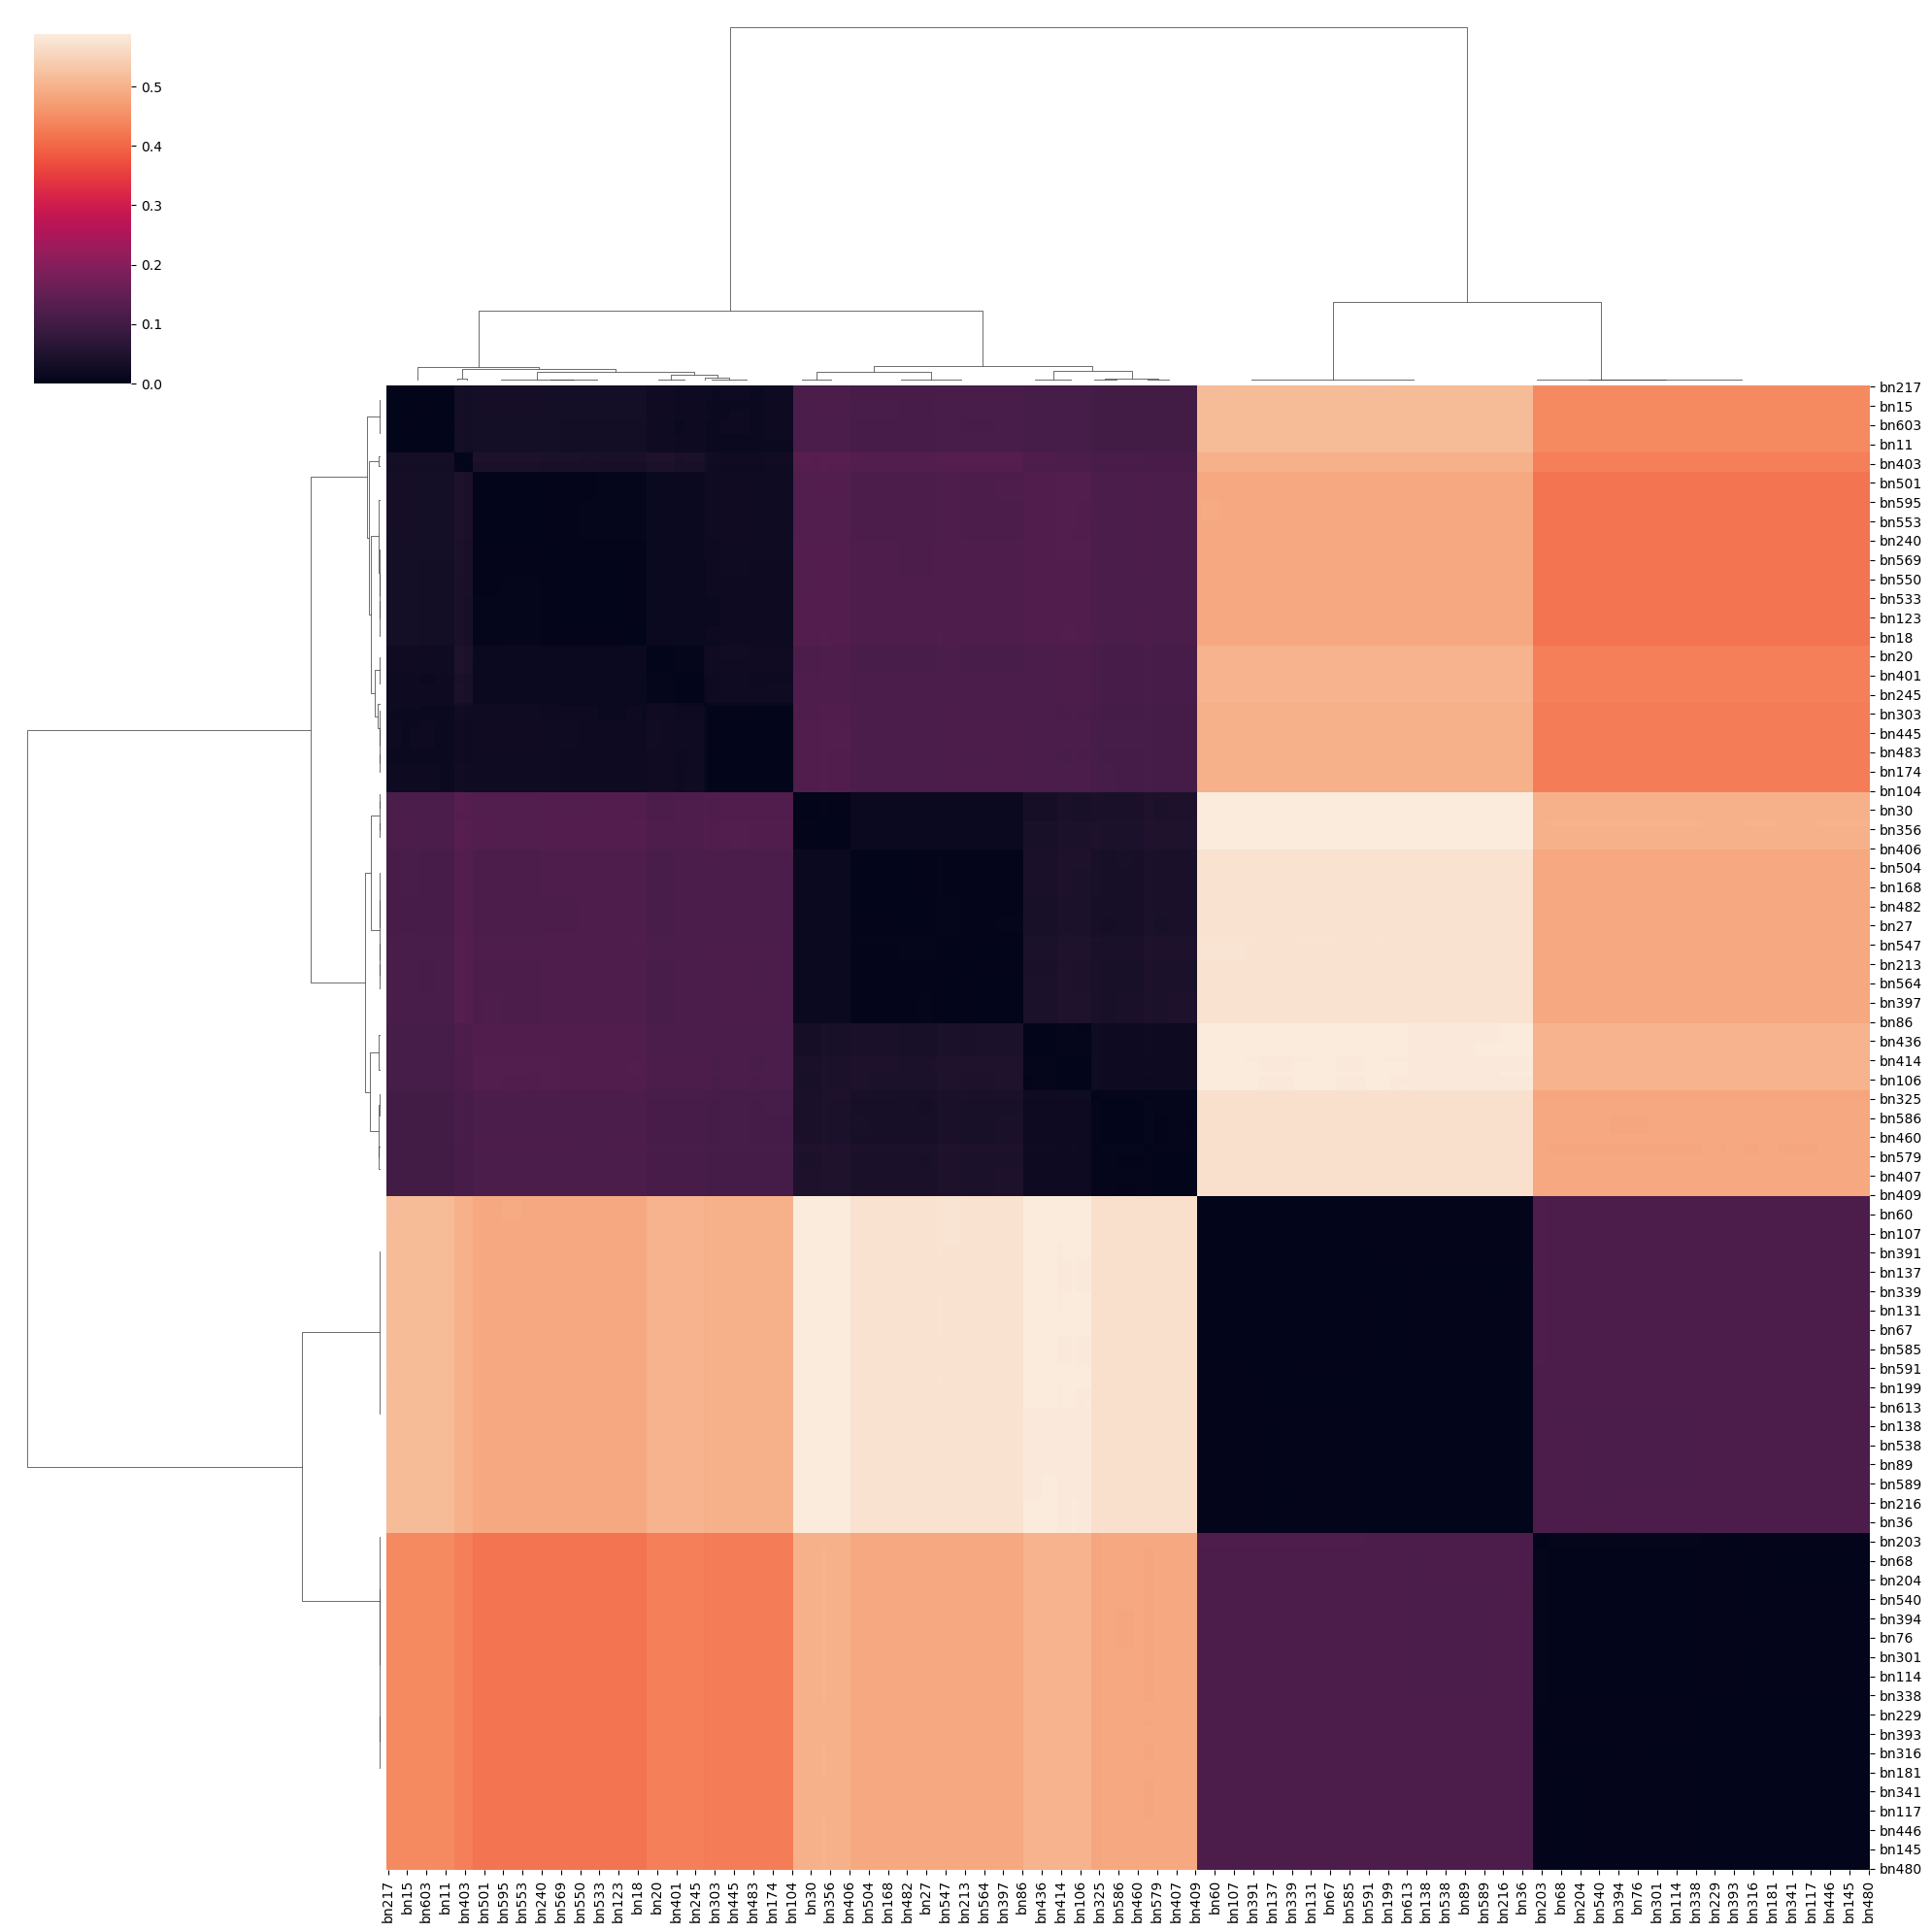

In [11]:
# Get model_id
model_id = list(pca_mat.model_id.cat.categories)

# Compact data into the right format
kmean_cluster = pca_mat.groupby(['model_id','timepoint'])[['pca1','pca2']].mean()

# Calculate Euclidean distances between clusters
distance_matrix = pd.DataFrame()
for i in model_id:
    time_series1 = np.array(kmean_cluster.loc[i])
    distance_cluster = []
    for j in model_id:
        time_series2 = np.array(kmean_cluster.loc[j])
        distance = np.sqrt(np.sum((time_series1 - time_series2)**2))
        distance_cluster.append(distance)
    distance_matrix = pd.concat([distance_matrix,pd.DataFrame(distance_cluster)],axis = 1)
distance_matrix.columns = model_id
distance_matrix.index = model_id

# Plot Euclidean distance using clustermap
g = sns.clustermap(distance_matrix, figsize = (20,20))

# Hiding the row dendrogram
#g.ax_row_dendrogram.set_visible(False)

# Hiding the column dendrogram
#g.ax_col_dendrogram.set_visible(False)

plt.show()

# Trajectory comparison using single variable from PCA

In [13]:
import tslearn
from tslearn.datasets import CachedDatasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.preprocessing import TimeSeriesResampler
import numpy


seed = 0
numpy.random.seed(seed)

Euclidean k-means
0.000 --> 0.000 --> 0.000 --> 


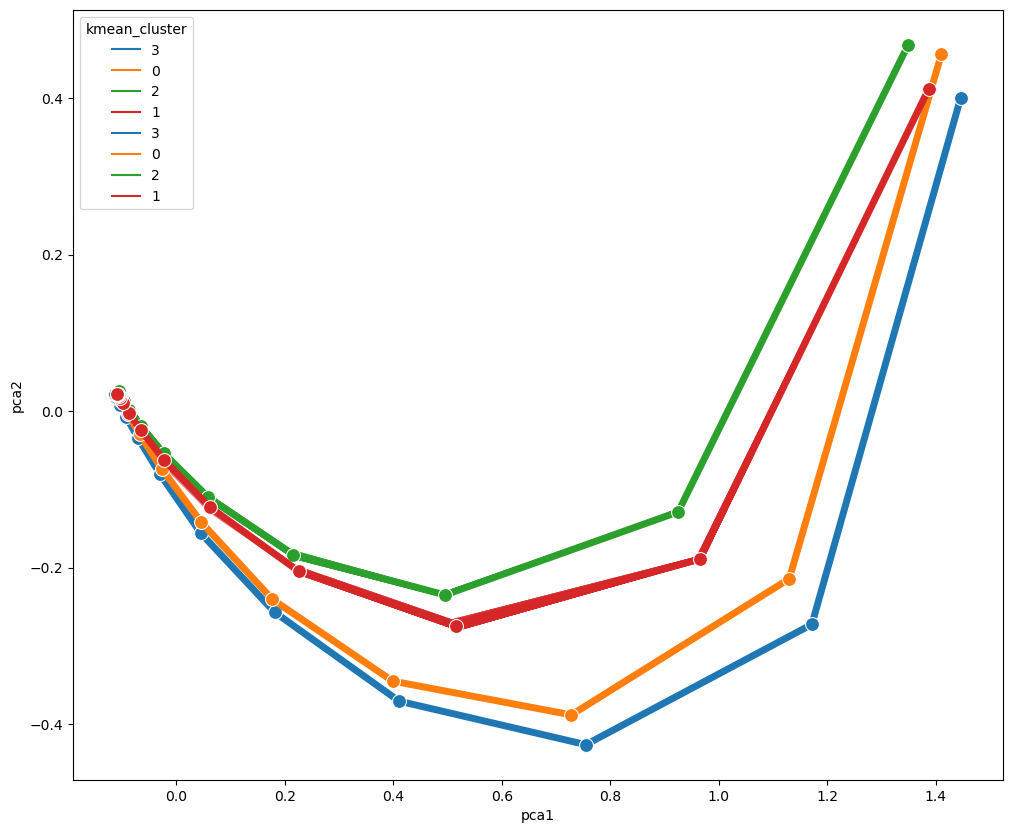

In [14]:
model_name = pca_mat.model_id.cat.categories

model_pca_all = {}
for i in model_name:
    model_pca = pca_mat.loc[pca_mat.model_id == i,['pca1','pca2']].values
    model_pca_all[i] = numpy.array(model_pca)

pca_all_trajectory = numpy.array(list(model_pca_all.values()))

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=4, verbose=True, random_state=seed)
y_pred = km.fit_predict(pca_all_trajectory)


# Plot the trajectory
cluster_dict = dict(zip(list(model_name),list(y_pred)))
pca_mat['kmean_cluster'] = pca_mat['model_id']
pca_mat['kmean_cluster'] = pca_mat['kmean_cluster'].replace(cluster_dict)

## Calculate the mean position
kmean_cluster = pca_mat.groupby(['timepoint','kmean_cluster'])[['pca1','pca2']].mean()

## Plot with Seaborn
import seaborn as sns
with rc_context({"figure.figsize": (12, 10)}):
    plot = sns.lineplot(data = pca_mat, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster', units = 'model_id', estimator = None, lw=2, alpha = .1,
                        sort = False)
    plot.get_legend().remove()

    plot2 = sns.lineplot(data = kmean_cluster, 
                        x = 'pca1',y='pca2',
                        hue = 'kmean_cluster',
                        sort = False, marker = 'o', linewidth = 5, markersize = 10)

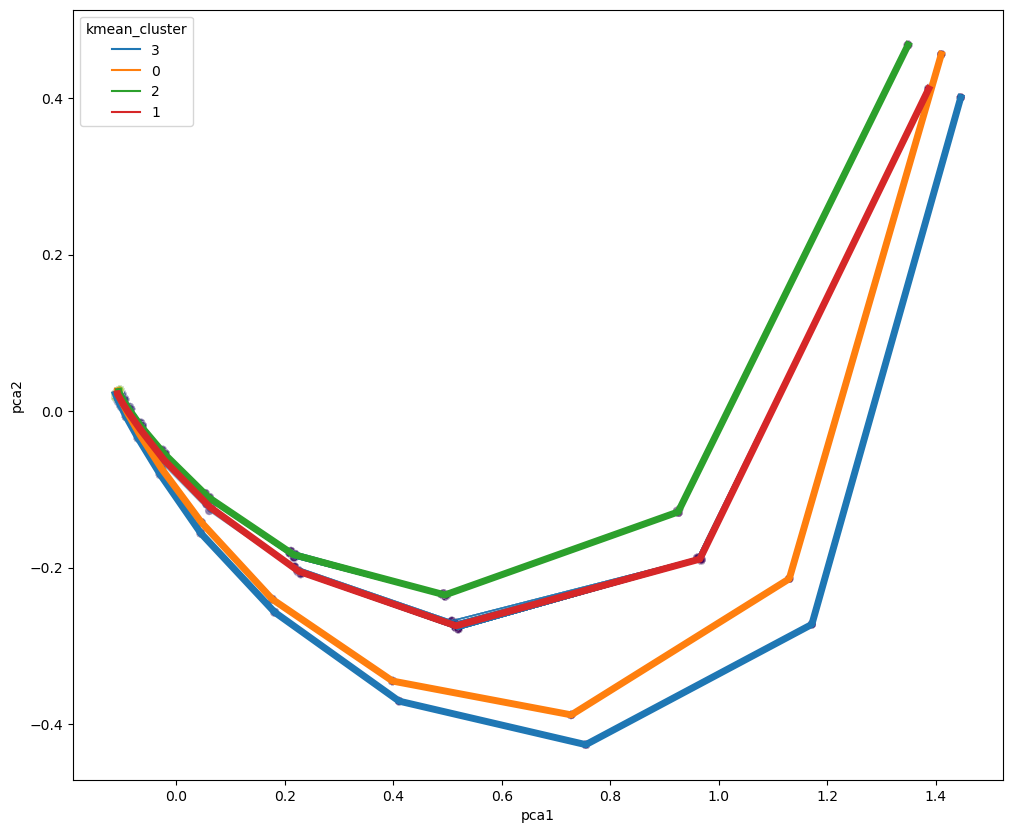

In [15]:
with rc_context({"figure.figsize": (12, 10)}):
    plot1 = sns.scatterplot(data = pca_mat, 
                x = 'pca1',y='pca2',
                c = pca_mat.timepoint, alpha = .1)
    
    plot2 = sns.lineplot(data = pca_mat, 
                x = 'pca1',y='pca2',
                units = 'model_id', estimator = None, lw=1, alpha = .1)
    
    plot3 = sns.lineplot(data = kmean_cluster, 
                            x = 'pca1',y='pca2',
                            hue = 'kmean_cluster',
                            sort = False, linewidth = 5, markersize = 10)
    
plt.show()

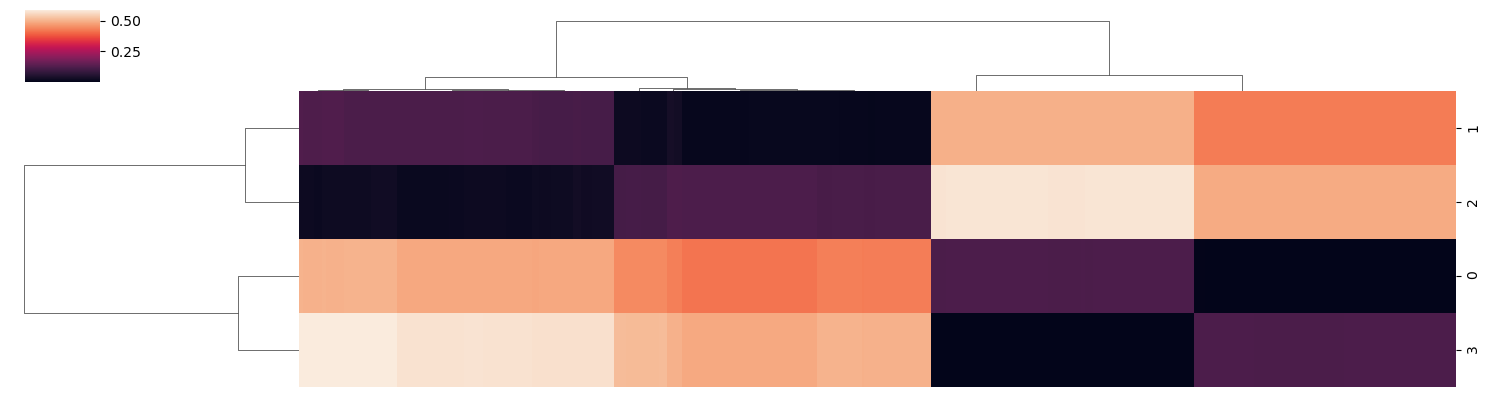

In [16]:
# Obtain the distance space from `tslearn`
distance_space = km.transform(pca_all_trajectory)
distance_space = pd.DataFrame(distance_space)
distance_space.index = list(model_pca_all.keys())

# Plot the distance space to each cluster for each model
sns.clustermap(distance_space.transpose(), figsize = (15,4), xticklabels=False)
plt.show()

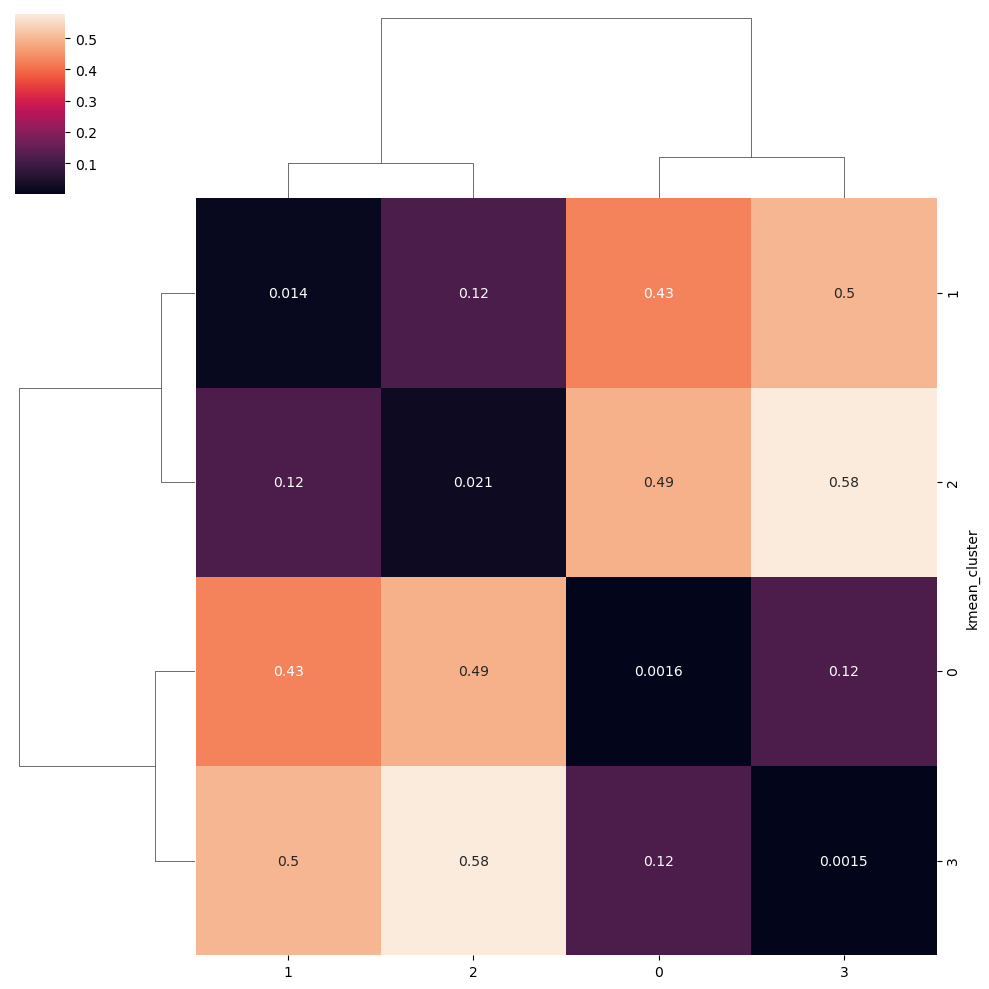

In [17]:
# Attach cluster information
distance_space['kmean_cluster'] = list(distance_space.index)
distance_space['kmean_cluster'] = distance_space['kmean_cluster'].replace(cluster_dict)
distance_space_group = distance_space.groupby(['kmean_cluster']).mean()

# Plot the distance space by group
sns.clustermap(distance_space_group, figsize = (10,10), annot = True)
plt.show()

In [23]:
pd.Series(cluster_dict).to_csv(output_dir + project + '_cluster.csv')

In [42]:
model_cluster = pd.DataFrame.from_dict(cluster_dict, orient = 'index', columns = ['cluster'])
model_cluster.to_csv(work_dir + '/model_cluster.csv')